## Detecting Hate & Offensive Speech

Dataset Source: https://www.kaggle.com/datasets/subhajournal/normal-hate-and-offensive-speeches

#### Import Necessary Libraries

In [1]:
import os, sys
os.environ['TOKENIZERS_PARALLELISM']='false'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datasets
from datasets import Dataset, DatasetDict

import torch

import transformers
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import TrainingArguments, Trainer, set_seed, DataCollatorWithPadding

import evaluate

!git lfs install

NOTE: Redirects are currently not supported in Windows or MacOs.


Git LFS initialized.


#### Display Library Versions

In [2]:
print("Python:".rjust(15), sys.version[0:6])
print("NumPy:".rjust(15), np.__version__)
print("Pandas:".rjust(15), pd.__version__)
print("Datasets:".rjust(15), datasets.__version__)
print("Transformers:".rjust(15), transformers.__version__)
print("Torch:".rjust(15), torch.__version__)
print("Evaluate:".rjust(15), evaluate.__version__)

        Python: 3.9.12
         NumPy: 1.24.2
        Pandas: 1.5.0
      Datasets: 2.9.0
  Transformers: 4.26.1
         Torch: 1.12.1
      Evaluate: 0.4.0


#### Load & Start Preprocessing Dataset

In [3]:
parent_dir = "/Users/briandunn/Desktop/nlp_ds/Hate & Offensive Speech"

unique_classes = ["Normal", "Hate", "Offensive"]

data = pd.DataFrame()

### loop through all three classes ('Normal', 'Hate', 'Offensive')
for class_name in unique_classes:
    for x in range(4):
        temp_df = pd.DataFrame()
        file_name = class_name + "_Speeches_" + str(x + 1) + ".csv"
        data_file_name = os.path.join(parent_dir, file_name)
        temp_df = pd.read_csv(data_file_name, usecols=[3])
        temp_df['label'] = class_name
        data = pd.concat([temp_df, data]) 

data.rename(columns={"full_text": "text"}, inplace=True)

data

,text,label
0,Republicans need to go on the offensive! They ...,Offensive
1,&gt; Make fun of people who lost their familie...,Offensive
2,You're missing my point entirely. I don't give...,Offensive
3,Wet leg quoting Alex turner’s Brit acceptance ...,Offensive
4,"@SammiePressdee Sir Stephen Sedley said: ""Free...",Offensive
...,...,...
218,@KumudShankar @nandtara @MoatasimSolkar @Gauta...,Normal
219,There’s no point dropping speech when he is no...,Normal
220,harry is one of the most humble musicians i kn...,Normal
221,Bro want the biggest most political arc in rec...,Normal


#### Define Dictionaries to Convert Between String & Integer Class Values

In [4]:
id2label = {idx:label for idx, label in enumerate(unique_classes)}
label2id = {label:idx for idx, label in enumerate(unique_classes)}
NUM_OF_LABELS = len(unique_classes)

#### Visual: Histogram of Text Lengths

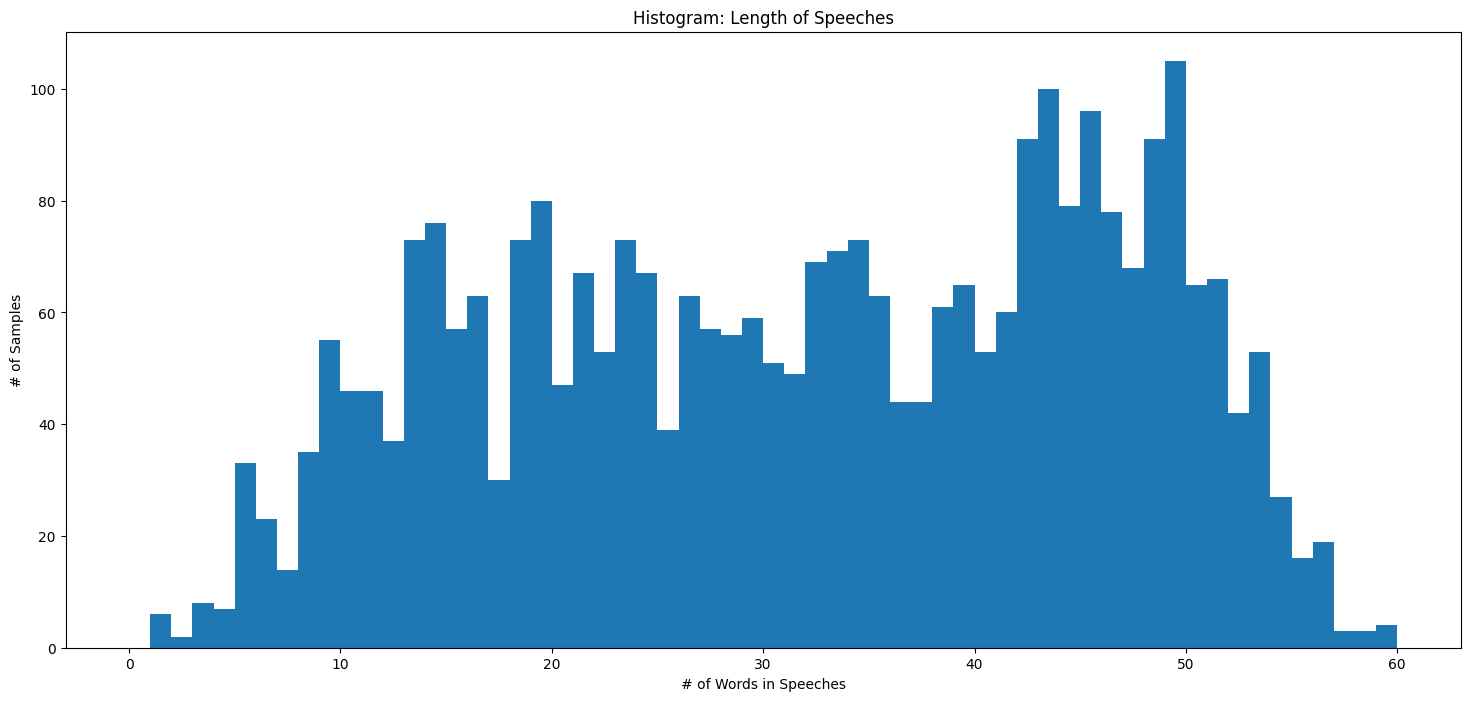

The maximum length of Speeches is 88 words.


In [5]:
data['text_length'] = data['text'].str.split().str.len()

n_bin=60
data.hist('text_length', grid=False, figsize=(18,8), range=(0,n_bin), bins=n_bin)
plt.title('Histogram: Length of Speeches')
plt.xlabel('# of Words in Speeches')
plt.ylabel('# of Samples')
plt.show()

print(f"The maximum length of Speeches is {max(data['text_length'])} words.")

#### Visual: Tweet Length by Class

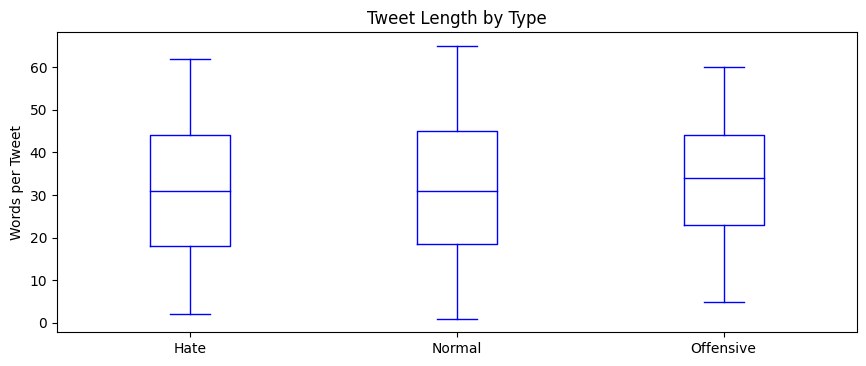

In [6]:
data.boxplot("text_length", by="label", grid=False, showfliers=False, color="Blue", figsize=(10,4))

plt.suptitle('')
plt.title('Tweet Length by Type')
plt.xlabel('')
plt.ylabel('Words per Tweet')
plt.show()

#### Final Data Preprocessing

In [7]:
data = data[data["text_length"] < 57]

data = data.drop(columns=["text_length"])

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3044 entries, 0 to 222
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3044 non-null   object
 1   label   3044 non-null   object
dtypes: object(2)
memory usage: 71.3+ KB


#### Number of Samples in Each Class

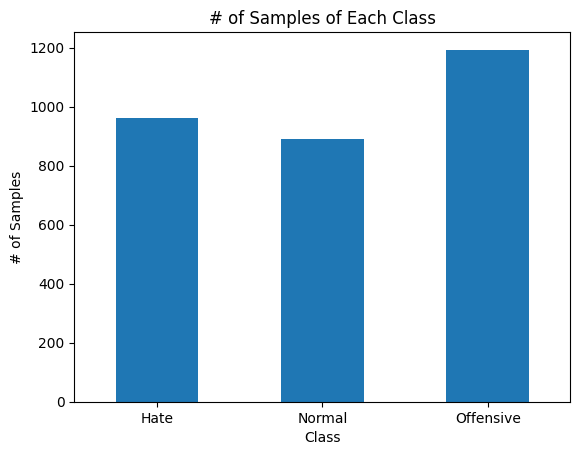

In [8]:
class_counts = data.groupby("label").count()

class_counts.plot.bar()
plt.suptitle('')
plt.title('# of Samples of Each Class')
plt.xlabel('Class')
plt.ylabel('# of Samples')
plt.xticks(rotation = 0)
plt.legend('', frameon=False)
plt.show()

#### Convert Class Values From String to Integer & Convert DataFrame to Dataset

In [9]:
data = data.replace(label2id)

dataset = Dataset.from_pandas(data)

#### Split Dataset into Training, Testing & Evaluation Datasets

In [10]:
train_testEval = dataset.train_test_split(train_size=0.80)
test_eval = train_testEval['test'].train_test_split(train_size=0.50)

ds = DatasetDict({
    'train' : train_testEval['train'],
    'test' : test_eval['train'],
    'eval' : test_eval['test'],
})

print("Training Dataset Shape:", ds['train'].shape)
print("Testing Dataset Shape:", ds['test'].shape)
print("Evaluation Dataset Shape:", ds['eval'].shape)

Training Dataset Shape: (2435, 3)
Testing Dataset Shape: (304, 3)
Evaluation Dataset Shape: (305, 3)


#### Basic Values/Constants

In [11]:
set_seed = 42
NUM_OF_EPOCHS = 3

BATCH_SIZE = 64
LEARNING_RATE = 2e-5

MAX_LENGTH = int(56 * 1.3)
MODEL_CKPT = "GroNLP/hateBERT"
MODEL_NAME = MODEL_CKPT.split("/")[-1] + "-Hate_Offensive_or_Normal_Speech"

METRIC_NAME = "f1"
DEVICE = torch.device("cpu")

print(f"This project will utilize the {str(DEVICE).upper()} to train and evaluate.")
print(f"This project will have a maximum length for the input text of {MAX_LENGTH} tokens.")
print(f"The model checkpoint used for this project is: {MODEL_CKPT}")

This project will utilize the CPU to train and evaluate.
This project will have a maximum length for the input text of 72 tokens.
The model checkpoint used for this project is: GroNLP/hateBERT


#### Tokenize Entire Dataset

In [12]:
# Define the Tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT)

# Method to Tokenize each Sample in the Dataset
def tokenize(batch):
    return tokenizer(batch['text'], 
                     padding=True, 
                     truncation=True, 
                     max_length=MAX_LENGTH, 
                     return_tensors="pt")

# Map the 'Tokenize' Method to All Samples in the Entire Dataset
encoded_data = ds.map(tokenize, batched=True, batch_size=None)

print('training data shape:', encoded_data['train'].shape)
print('testing data shape:', encoded_data['test'].shape)
print('validation data shape:', encoded_data['eval'].shape)

print(encoded_data['train'].features)
print(encoded_data['train'])

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

training data shape: (2435, 6)
testing data shape: (304, 6)
validation data shape: (305, 6)
{'text': Value(dtype='string', id=None), 'label': Value(dtype='int64', id=None), '__index_level_0__': Value(dtype='int64', id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}
Dataset({
    features: ['text', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 2435
})


#### Instantiate Model

In [13]:
model = (
    AutoModelForSequenceClassification.from_pretrained(
        MODEL_CKPT,
        num_labels=NUM_OF_LABELS
    ).to(DEVICE))

A Jupyter Widget

Some weights of the model checkpoint at GroNLP/hateBERT were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly

#### Define Function to Compute Metrics

In [14]:
def compute_metrics(p):
    accuracy_metric = evaluate.load("accuracy")
    accuracy = accuracy_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)['accuracy']
    
    ### ------------------- F1 scores -------------------
    
    f1_score_metric = evaluate.load("f1")
    weighted_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='weighted')["f1"]
    micro_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='micro')['f1']
    macro_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='macro')["f1"]
    
    ### ------------------- recall -------------------
    
    recall_metric = evaluate.load("recall")
    weighted_recall = recall_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='weighted')["recall"]
    micro_recall = recall_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='micro')["recall"]
    macro_recall = recall_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='macro')["recall"]
    
    ### ------------------- precision -------------------
    
    precision_metric = evaluate.load("precision")
    weighted_precision = precision_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='weighted')["precision"]
    micro_precision = precision_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='micro')["precision"]
    macro_precision = precision_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='macro')["precision"]
    
    return {"accuracy" : accuracy, 
            "Weighted F1" : weighted_f1_score,
            "Micro F1" : micro_f1_score,
            "Macro F1" : macro_f1_score,
            "Weighted Recall" : weighted_recall,
            "Micro Recall" : micro_recall,
            "Macro Recall" : macro_recall,
            "Weighted Precision" : weighted_precision,
            "Micro Precision" : micro_precision,
            "Macro Precision" : macro_precision
            }

#### Define TrainingArguments

In [15]:
training_args = TrainingArguments(
    output_dir=MODEL_NAME,
    num_train_epochs=NUM_OF_EPOCHS,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE, 
    per_device_eval_batch_size=BATCH_SIZE, 
    weight_decay=0.01,
    log_level="error",
    logging_strategy='epoch', 
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_first_step=True,
    load_best_model_at_end=True,
    disable_tqdm=False,
    hub_private_repo=True,
    push_to_hub=True
)

#### Define Data Collator

In [16]:
data_collator = DataCollatorWithPadding(tokenizer, padding=True)

#### Subclass Trainer to Handle Class Imbalance

In [17]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = torch.nn.CrossEntropyLoss(weight=torch.tensor([1.0, 2.0, 3.0]))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

#### Instantiate Trainer

In [18]:
trainer = CustomTrainer(model=model, 
                  args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=encoded_data['train'], 
                  eval_dataset=encoded_data['eval'], 
                  data_collator=data_collator,
                  tokenizer=tokenizer)

Cloning https://huggingface.co/DunnBC22/hateBERT-Hate_Offensive_or_Normal_Speech into local empty directory.


#### Train Model

In [19]:
train_results = trainer.train()

/Users/briandunn/Documents/nlpnn/nlp_ml/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


A Jupyter Widget

{'loss': 1.1956, 'learning_rate': 1.982905982905983e-05, 'epoch': 0.03}
{'loss': 0.8958, 'learning_rate': 1.3333333333333333e-05, 'epoch': 1.0}


A Jupyter Widget

{'eval_loss': 0.6817051768302917, 'eval_accuracy': 0.5508196721311476, 'eval_Weighted F1': 0.4791953207133972, 'eval_Micro F1': 0.5508196721311476, 'eval_Macro F1': 0.43948227999718165, 'eval_Weighted Recall': 0.5508196721311476, 'eval_Micro Recall': 0.5508196721311476, 'eval_Macro Recall': 0.48530194759702955, 'eval_Weighted Precision': 0.7546806994131118, 'eval_Micro Precision': 0.5508196721311476, 'eval_Macro Precision': 0.7906259636139378, 'eval_runtime': 96.6035, 'eval_samples_per_second': 3.157, 'eval_steps_per_second': 0.052, 'epoch': 1.0}
{'loss': 0.4625, 'learning_rate': 6.666666666666667e-06, 'epoch': 2.0}


A Jupyter Widget

{'eval_loss': 0.24483025074005127, 'eval_accuracy': 0.9245901639344263, 'eval_Weighted F1': 0.9229623065026865, 'eval_Micro F1': 0.9245901639344263, 'eval_Macro F1': 0.9169939643489605, 'eval_Weighted Recall': 0.9245901639344263, 'eval_Micro Recall': 0.9245901639344263, 'eval_Macro Recall': 0.9102864348765989, 'eval_Weighted Precision': 0.9263321742010266, 'eval_Micro Precision': 0.9245901639344263, 'eval_Macro Precision': 0.9296209962876629, 'eval_runtime': 96.1875, 'eval_samples_per_second': 3.171, 'eval_steps_per_second': 0.052, 'epoch': 2.0}
{'loss': 0.2071, 'learning_rate': 0.0, 'epoch': 3.0}


A Jupyter Widget

{'eval_loss': 0.165512353181839, 'eval_accuracy': 0.940983606557377, 'eval_Weighted F1': 0.939490046121732, 'eval_Micro F1': 0.940983606557377, 'eval_Macro F1': 0.9350655283433574, 'eval_Weighted Recall': 0.940983606557377, 'eval_Micro Recall': 0.940983606557377, 'eval_Macro Recall': 0.9272583518485158, 'eval_Weighted Precision': 0.9447019789154691, 'eval_Micro Precision': 0.940983606557377, 'eval_Macro Precision': 0.9509891570960273, 'eval_runtime': 98.0446, 'eval_samples_per_second': 3.111, 'eval_steps_per_second': 0.051, 'epoch': 3.0}
{'train_runtime': 7460.0398, 'train_samples_per_second': 0.979, 'train_steps_per_second': 0.016, 'train_loss': 0.5243594890985733, 'epoch': 3.0}


#### Save Model & Metrics on Training Dataset

In [20]:
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


A Jupyter Widget

A Jupyter Widget

remote: Scanning LFS files of refs/heads/main for validity...        
remote: LFS file scan complete.        
To https://huggingface.co/DunnBC22/hateBERT-Hate_Offensive_or_Normal_Speech
   d346487..a6d3d2b  main -> main

To https://huggingface.co/DunnBC22/hateBERT-Hate_Offensive_or_Normal_Speech
   a6d3d2b..c71e039  main -> main



***** train metrics *****
  epoch                    =        3.0
  train_loss               =     0.5244
  train_runtime            = 2:04:20.03
  train_samples_per_second =      0.979
  train_steps_per_second   =      0.016


#### Evaluate Model

In [21]:
metrics = trainer.evaluate(encoded_data['eval'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

A Jupyter Widget

***** eval metrics *****
  epoch                   =        3.0
  eval_Macro F1           =     0.9351
  eval_Macro Precision    =      0.951
  eval_Macro Recall       =     0.9273
  eval_Micro F1           =      0.941
  eval_Micro Precision    =      0.941
  eval_Micro Recall       =      0.941
  eval_Weighted F1        =     0.9395
  eval_Weighted Precision =     0.9447
  eval_Weighted Recall    =      0.941
  eval_accuracy           =      0.941
  eval_loss               =     0.1655
  eval_runtime            = 0:01:35.92
  eval_samples_per_second =       3.18
  eval_steps_per_second   =      0.052


#### Push Model to HuggingFace Hub

In [22]:
trainer.push_to_hub(commit_message="All Dunn!!!")

A Jupyter Widget

remote: Scanning LFS files of refs/heads/main for validity...        
remote: LFS file scan complete.        
To https://huggingface.co/DunnBC22/hateBERT-Hate_Offensive_or_Normal_Speech
   c71e039..09d8e0b  main -> main



'https://huggingface.co/DunnBC22/hateBERT-Hate_Offensive_or_Normal_Speech/commit/09d8e0b8eafbab9f8f5f9fc74a14bb4a407d7d2e'

### Notes & Other Takeaways From This Project
****
- This is one of four projects using this same dataset to see which model best predicts if speech is hateful, offensive, or normal.
****

### Citations

- Model Checkpoint
    - @inproceedings{caselli-etal-2021-hatebert,
    \ttitle = "{H}ate{BERT}: Retraining {BERT} for Abusive Language Detection in {E}nglish",
    \tauthor = "Caselli, Tommaso  and
      Basile, Valerio  and
      Mitrovi{\'c}, Jelena  and
      Granitzer, Michael",
    \tbooktitle = "Proceedings of the 5th Workshop on Online Abuse and Harms (WOAH 2021)",
    \tmonth = aug,
    \tyear = "2021",
    \taddress = "Online",
    \tpublisher = "Association for Computational Linguistics",
    \tturl = "https://aclanthology.org/2021.woah-1.3",
    \tdoi = "10.18653/v1/2021.woah-1.3",
    \tpages = "17--25",
    \tabstract = "We introduce HateBERT, a re-trained BERT model for abusive language detection in English. The model was trained on RAL-E, a large-scale dataset of Reddit comments in English from communities banned for being offensive, abusive, or hateful that we have curated and made available to the public. We present the results of a detailed comparison between a general pre-trained language model and the retrained version on three English datasets for offensive, abusive language and hate speech detection tasks. In all datasets, HateBERT outperforms the corresponding general BERT model. We also discuss a battery of experiments comparing the portability of the fine-tuned models across the datasets, suggesting that portability is affected by compatibility of the annotated phenomena.",
}